In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import utils

In [5]:
data_arr = utils.load_data(
    "/content/drive/MyDrive/NN/ndvi_timeseries/arrays", mask=False
)
nodataval = 0
data_arr = np.where(np.isnan(data_arr), nodataval, data_arr)

Loading variables: ['ndvi', 't2m', 'tp']
ndvi stats:
 - Mean: 0.5446307436198691
 - Std: 0.19814770380475102
 - Min: 0.0769230769230769
 - Max: 0.9590346153846169
t2m stats:
 - Mean: 278.7075
 - Std: 11.052695
 - Min: 240.43307
 - Max: 300.77982
tp stats:
 - Mean: 0.0012314396
 - Std: 0.00043459417
 - Min: 0.00014625948
 - Max: 0.0031044537
Data loaded with shape: (640, 74, 147, 3)


In [7]:
inputs_all = data_arr
outputs_all = data_arr[:, :, :, 0]
(
    inputs_train,
    outputs_train,
    inputs_val,
    outputs_val,
    inputs_test,
    outputs_test,
) = utils.normalize_and_split_data(inputs_all, outputs_all)

(384, 74, 147, 3)
Input train shape: (383, 74, 147, 3)
Output train shape: (383, 74, 147, 1)
Input val shape: (127, 74, 147, 3)
Output val shape: (127, 74, 147, 1)
Input test shape: (127, 74, 147, 3)
Output test shape: (127, 74, 147, 1)


In [49]:
model = utils.build_model(inputs_train)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.002),
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 74, 147,    0         
                             3)]                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 74, 147, 3   40448     
                             2)                                  
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 74, 147, 6   221440    
                             4)                                  
                                                                 
 conv3d_2 (Conv3D)           (None, None, 74, 147, 1   1729      
                             )                                   
                                                                 
Total params: 263617 (1.01 MB)
Trainable params: 263617 (1.

In [50]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
callbacks = [early_stopping, reduce_lr]

# Epochs
epochs = 50

# Fit the model
training_data = model.fit(
    np.expand_dims(inputs_train, 0),
    np.expand_dims(outputs_train, 0),
    epochs=epochs,
    batch_size=1,
    validation_data=(np.expand_dims(inputs_val, 0), np.expand_dims(outputs_val, 0)),
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.0489 - val_loss: 0.0571 - lr: 0.0020
Epoch 2/50
1/1 [==============================] - 16s 16s/step - loss: 0.0606 - val_loss: 0.0910 - lr: 0.0020
Epoch 3/50
1/1 [==============================] - 17s 17s/step - loss: 0.0844 - val_loss: 0.0391 - lr: 0.0020
Epoch 4/50
1/1 [==============================] - 17s 17s/step - loss: 0.0384 - val_loss: 0.0285 - lr: 0.0020
Epoch 5/50
1/1 [==============================] - 16s 16s/step - loss: 0.0276 - val_loss: 0.0319 - lr: 0.0020
Epoch 6/50
1/1 [==============================] - 16s 16s/step - loss: 0.0306 - val_loss: 0.0272 - lr: 0.0020
Epoch 7/50
1/1 [==============================] - 19s 19s/step - loss: 0.0261 - val_loss: 0.0274 - lr: 0.0020
Epoch 8/50
1/1 [==============================] - 17s 17s/step - loss: 0.0275 - val_loss: 0.0259 - lr: 0.0020
Epoch 9/50
1/1 [==============================] - 16s 16s/step - loss: 0.0261 - val_loss: 0.0240 - lr: 0.0020
Epoch 10/5

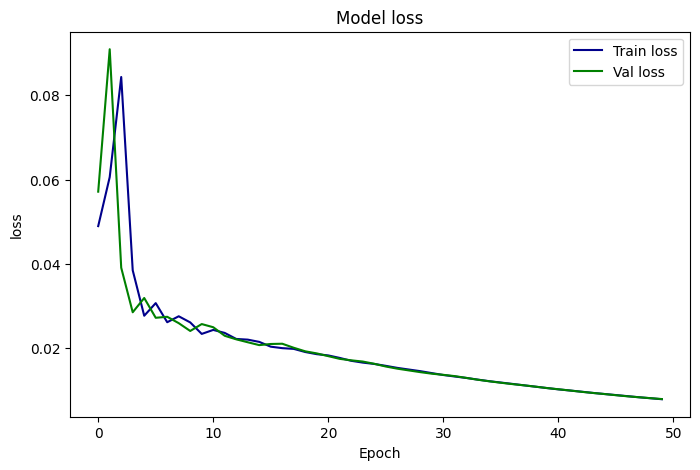

In [51]:
metrics = ["loss"]

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(training_data.history[metric], c="darkblue", label=f"Train {metric}")
    plt.plot(training_data.history[f"val_{metric}"], c="green", label=f"Val {metric}")

    plt.title(f"Model {metric}")
    plt.ylabel(metric)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [81]:
score = model.evaluate(
    np.expand_dims(inputs_test, 0),
    np.expand_dims(outputs_test, 0),
    batch_size=1,
)
predictions = model.predict(np.expand_dims(inputs_test, 0))

np.save("test_arrays", predictions)
print(score)

1/1 [==============================] - 1s 1s/step
0.007414879743009806


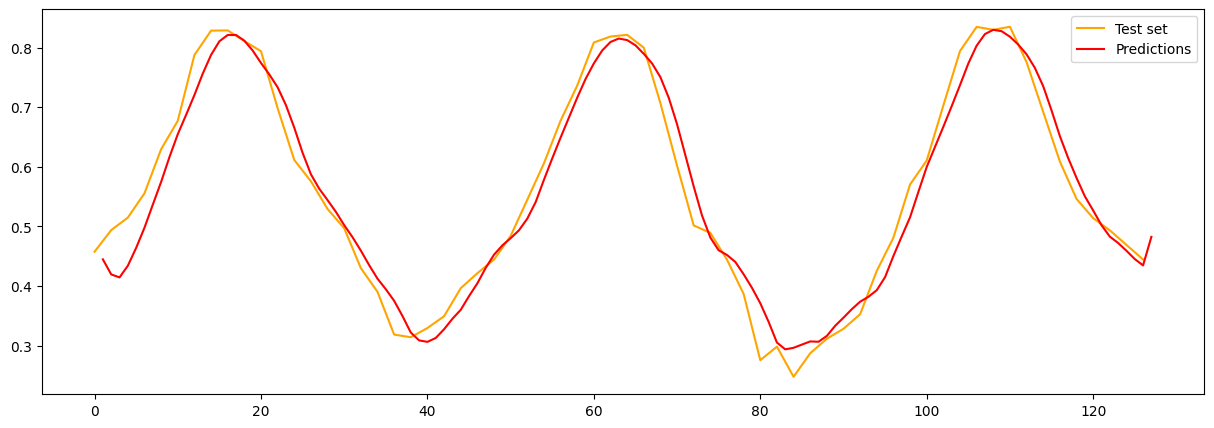

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))

existing_y = np.nanmean(
    np.reshape(
        outputs_test,
        (outputs_test.shape[0], outputs_test.shape[1] * outputs_test.shape[2]),
    ),
    axis=1,
)
existing_x = np.array(range(len(existing_y)))
later_x = existing_x + 1
found_y = np.nanmean(
    np.reshape(
        predictions[0],
        (predictions.shape[1], predictions.shape[2] * predictions.shape[3]),
    ),
    axis=1,
)

plt.plot(existing_x, existing_y, c="orange", label="Test set")
plt.plot(later_x, found_y, c="red", label="Predictions")
plt.legend()
plt.show()

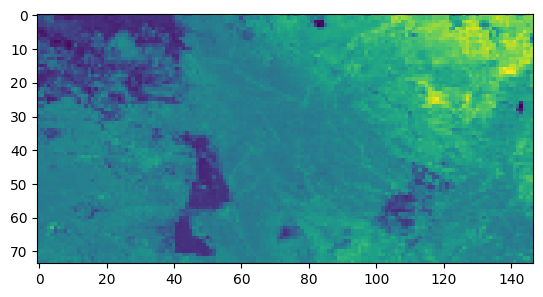

In [57]:
# Last NDVI timestep before the prediction
plt.imshow(outputs_test[-1, :, :, 0])

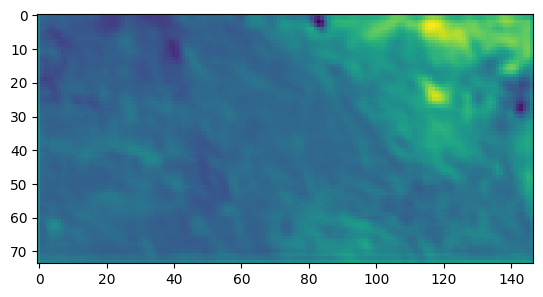

In [58]:
# Prediction
plt.imshow(predictions[0, -1, :, :, 0])

In [59]:
# RMSE of the prediction
rmse = np.sqrt(
    mean_squared_error(outputs_test[-1, :, :, 0], predictions[0, -1, :, :, 0])
)
rmse

0.08944053104334687